# Advanced Lane Finding -- Project 4

## Steps

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

- Plotting Pipeline onto a Test Image
- Plotting Pipeline onto a Test Video


### Step 1 -- Camera calibration

In [1]:
import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
%matplotlib inline

Found points for ./camera_cal/calibration10.jpg
Found points for ./camera_cal/calibration6.jpg
Found points for ./camera_cal/calibration9.jpg
Found points for ./camera_cal/calibration7.jpg
Found points for ./camera_cal/calibration19.jpg
Found points for ./camera_cal/calibration20.jpg
Found points for ./camera_cal/calibration16.jpg
Found points for ./camera_cal/calibration17.jpg
Found points for ./camera_cal/calibration2.jpg
Found points for ./camera_cal/calibration8.jpg
Found points for ./camera_cal/calibration15.jpg
Found points for ./camera_cal/calibration3.jpg
Found points for ./camera_cal/calibration14.jpg
Found points for ./camera_cal/calibration11.jpg
Found points for ./camera_cal/calibration13.jpg
Found points for ./camera_cal/calibration12.jpg
Found points for ./camera_cal/calibration18.jpg


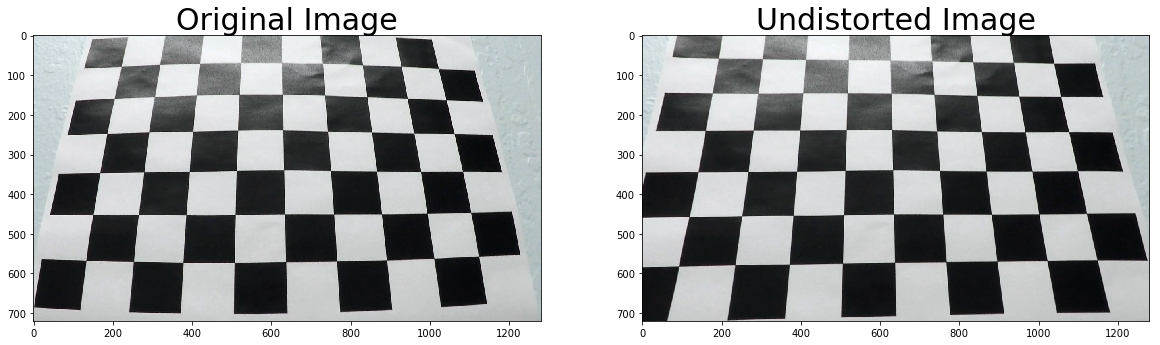

In [3]:
import cv2
import glob
import numpy as np
import pickle

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (8,5,0)
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points and image points
    if ret == True:
        print('Found points for', fname)
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = './output_images/corners_found' + str(idx) + '.jpg'
        cv2.imwrite(write_name, img)

# Load a sample calibration image for calibrating 
img = cv2.imread('./camera_cal/calibration3.jpg')

# Perform camera clibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)

# Save original for plotting
orig = img
orig_un = cv2.undistort(img, mtx, dist, None, mtx)

# Undistort and save all the calibration images
for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Undistort the image
    img_un = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('./output_images/undistorted' + str(idx) + '.jpg', img_un)

# Plot a sample undistored image 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(orig)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(orig_un)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
# Pickle the calibration
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

### Step 2 - Distortion correction

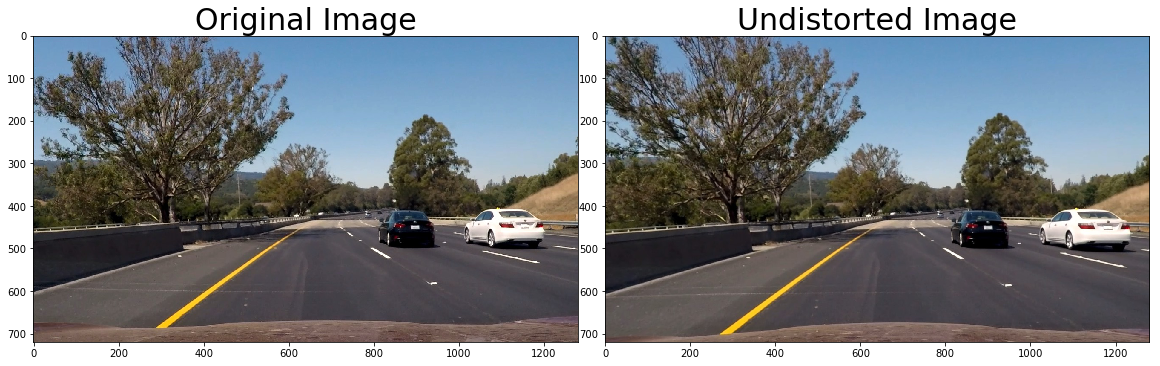

In [6]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Test image to demonstrate each step of the pipeline
test_img = cv2.imread('./test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_un = undistort(test_img)

# Plot test image undistored image 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_un)
ax2.set_title('Undistorted Image', fontsize=30)

### Step 3 -- Color/gradient threshold

In [31]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude of the gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0-255) then convert to type = np.uint8
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a mask of 1's where the scaled gradient magnitude is within the given thresholds
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    # Return binary output image
    return mag_binary


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate direction of gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a mask of 1's where the gradient direction is within the given thresholds
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return binary output image
    return dir_binary

def color_thresh(img, r_thresh=(0, 255), s_thresh=(0, 255)):
    # Separate the R channel
    r_channel = img[:,:,2]
    r_binary = np.zeros_like(img[:,:,0])
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined = np.zeros_like(img[:,:,0])
    combined[(s_binary == 1) | (r_binary == 1)] = 1

    return combined

In [32]:
def apply_gradient(img):
    # Gradient threshold 
    grad_binary = np.zeros_like(img[:,:,0])
    mag_binary = mag_thresh(img, sobel_kernel=9, thresh=(50, 255))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

    # Color threshold 
    color_binary = color_thresh(img, r_thresh=(220, 255), s_thresh=(150, 255))

    # Combine gradient and color thresholds
    combo_binary = np.zeros_like(img[:,:,0])
    combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255
    
    return combo_binary

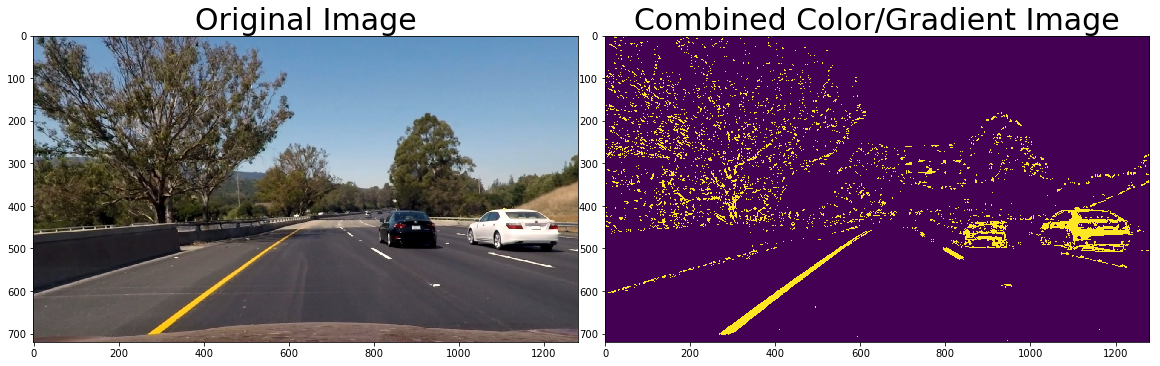

In [35]:
combined = apply_gradient(test_img_un)

# Visualize combined thresholds
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img_un)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined)
ax2.set_title('Combined Color/Gradient Image', fontsize=30)

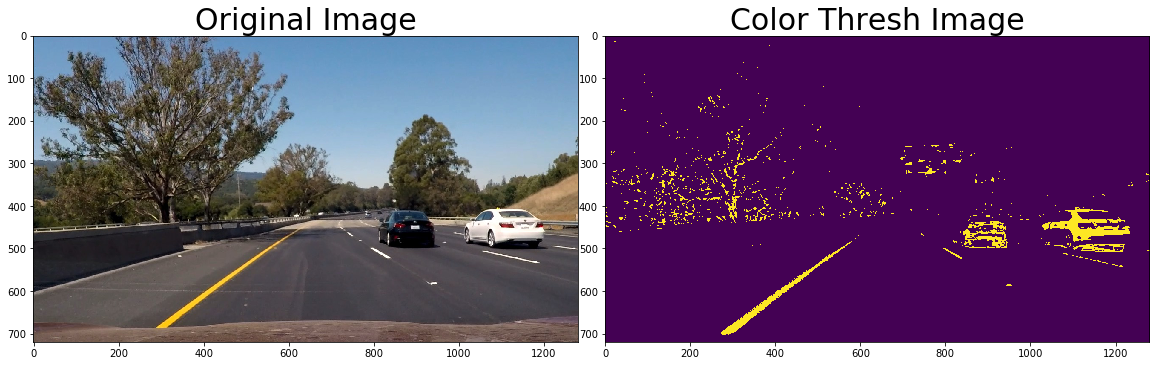

In [37]:
# Visualize only color threshold
color_binary = color_thresh(test_img_un, r_thresh=(220, 255), s_thresh=(150, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_binary)
ax2.set_title('Color Thresh Image', fontsize=30)

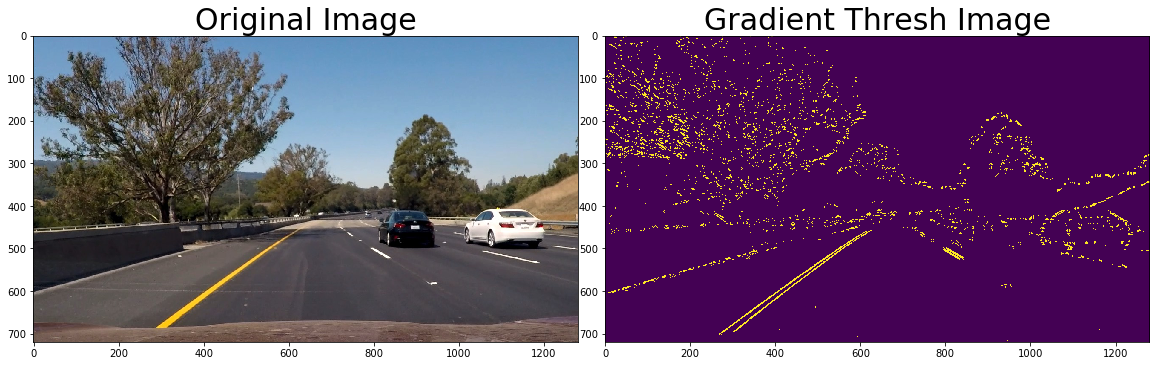

In [39]:
# Visualize only gradient thresholds
grad_binary = np.zeros_like(test_img_un[:,:,0])
mag_binary = mag_thresh(test_img_un, sobel_kernel=9, thresh=(50, 255))
dir_binary = dir_thresh(test_img_un, sobel_kernel=15, thresh=(0.7, 1.3))
grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary)
ax2.set_title('Gradient Thresh Image', fontsize=30)

### Step 4 - Perspective transform

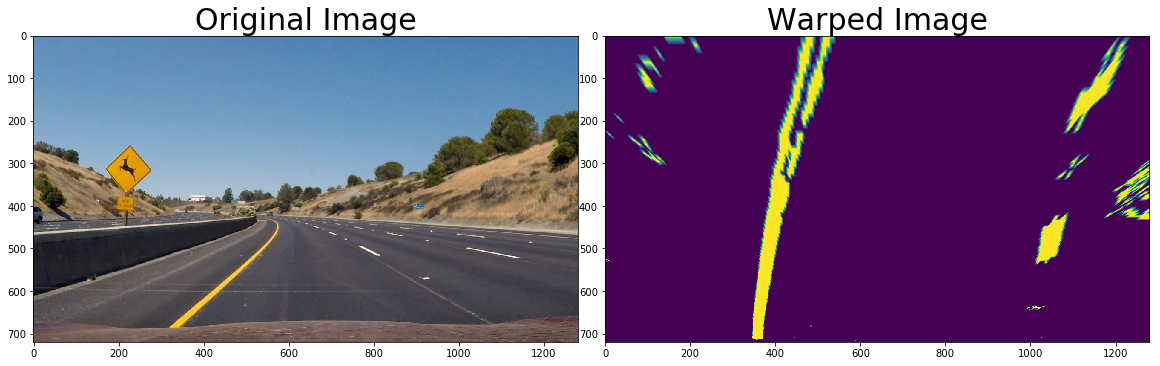

In [92]:
def shift_perspective(img):
    # Define perspective transform area
    img_size = (test_img.shape[1], test_img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1]/2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1]/2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # Perform the transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


# Plot test image perspective transform
warped, M, Minv = shift_perspective(combined)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

### Step 5 -- Detect lane lines

In [105]:
def detect_lines(img):
    binary_warped = img
    recent_left_xfitted = []
    recent_right_xfitted = []

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_idx = []
    right_lane_idx = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_idx.append(good_left_idx)
        right_lane_idx.append(good_right_idx)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_idx) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idx]))
        if len(good_right_idx) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_idx]))

    # Concatenate the arrays of indices
    left_lane_idx = np.concatenate(left_lane_idx)
    right_lane_idx = np.concatenate(right_lane_idx)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx]
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]

    # polynomial coefficients for the most recent fit
    current_left_fit = np.polyfit(lefty, leftx, 2)
    current_right_fit = np.polyfit(righty, rightx, 2)

    # x values of the last n fits of the left line
    recent_left_xfitted.append(current_left_fit)
    # x values of the last n fits of the right line
    recent_right_xfitted.append(current_right_fit)

    best_left_fit = np.mean(recent_left_xfitted[-min(15,len(recent_left_xfitted)):], axis=0)
    best_right_fit = np.mean(recent_right_xfitted[-min(15,len(recent_right_xfitted)):], axis=0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = best_left_fit[0]*ploty**2 + best_left_fit[1]*ploty + best_left_fit[2]
    right_fitx = best_right_fit[0]*ploty**2 + best_right_fit[1]*ploty + best_right_fit[2]

    return [ploty, left_fitx, right_fitx, left_lane_idx, right_lane_idx]


(720, 0)

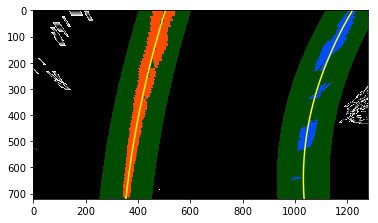

In [110]:
# Visualize lane plots on test image
ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds = detect_lines(warped)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Step 6 -- Determine the lane curvature

In [96]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def calc_roc(ploty, left_fitx, right_fitx):
    # Fit polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius_of_curvature = (left_curverad + right_curverad) / 2
    
    return [radius_of_curvature, left_curverad, right_curverad]

In [97]:
ploty, left_fitx, right_fitx = detect_lines(warped)
radius_of_curvature, left_curverad, right_curverad = calc_roc(ploty, left_fitx, right_fitx)
print('left:', left_curverad, 'm', ' right:', right_curverad, 'm', ' mean:', radius_of_curvature, 'm')

left: 1163.30397167 m  right: 361.677253882 m  mean: 762.490612774 m


### Step 7 -- Plotting Pipeline onto a Test Image

In [99]:
def draw_mask(original, warped, ploty, left_fitx, right_fitx, radius_of_curvature, Minv):
    img = original
    binary_warped = warped
    
    # Create an image to draw the lines
    warp_zero = np.zeros_like(binary_warped[:-20]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix
    unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original undistorted image
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

    # Calculate offset of the car between the lanes
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    line_base_pos = (camera_center - unwarped.shape[1] / 2) * xm_per_pix

    # Add curvature & offset to image
    cv2.putText(result, 'Radius of Curvature: ' + str(round(radius_of_curvature, 3)) + ' m',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle Distance from Center: '+ str(abs(round(line_base_pos, 3))) + ' m',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    return result

In [100]:
## PIPELINE

def pipeline(img):
    # Undistort the image
    un_img = undistort(img)

    # Apply lane detection thresholds
    combo_binary = apply_gradient(un_img)

    # Apply perspective shift to birds-eye-view
    binary_warped, M, Minv = shift_perspective(combo_binary)

    # Detect lines using shifting histogram
    [ploty, left_fitx, right_fitx] = detect_lines(binary_warped)

    # Calculate radius of cuvature
    [radius_of_curvature, left_curverad, right_curverad] = calc_roc(ploty, left_fitx, right_fitx)

    # Draw lane mask back onto original image
    result = draw_mask(img, binary_warped, ploty, left_fitx, right_fitx, radius_of_curvature, Minv)
    
    return result

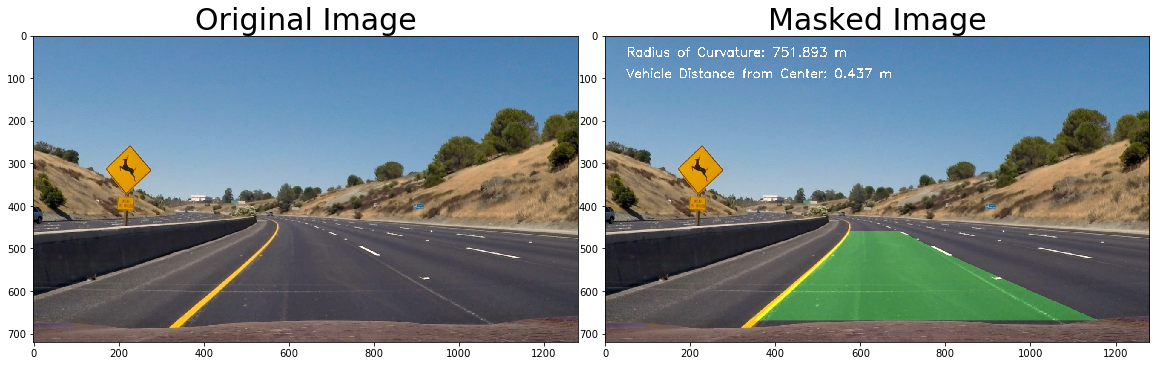

In [101]:
# Grab test img
# and test on pipeline
test2 = cv2.imread('./test_images/test2.jpg')
test2 = cv2.cvtColor(test2, cv2.COLOR_BGR2RGB)
result = pipeline(test2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Masked Image', fontsize=30)

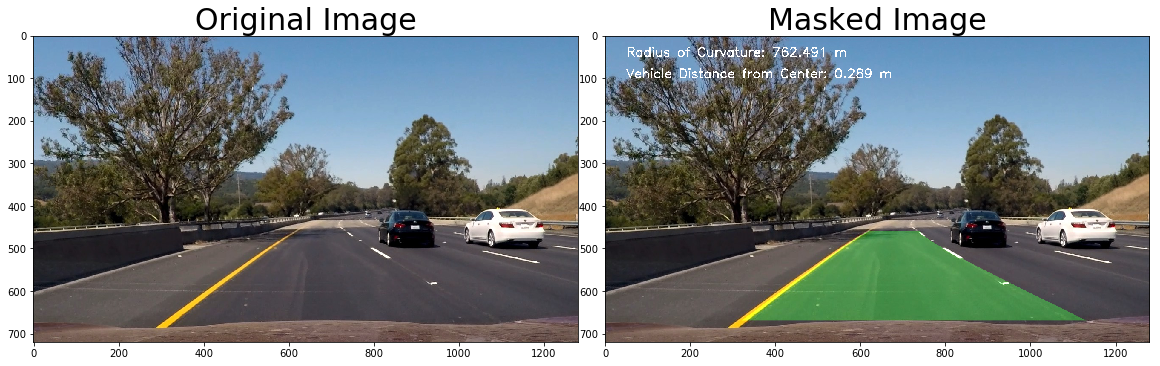

In [102]:
# Grab another test img
test6 = cv2.imread('./test_images/test6.jpg')
test6 = cv2.cvtColor(test6, cv2.COLOR_BGR2RGB)
result = pipeline(test6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test6)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Masked Image', fontsize=30)

### Step 8 -- Plotting Pipeline onto a Test Video

In [125]:
from moviepy.editor import VideoFileClip

test_video = './project_video.mp4'
output_video = './project_video_masked.mp4'

clip = VideoFileClip(test_video)
output_clip = clip.fl_image(pipeline)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./project_video_masked.mp4
[MoviePy] Writing video ./project_video_masked.mp4


100%|█████████▉| 1260/1261 [06:21<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_masked.mp4 

